In [36]:
import pandas as pd
import numpy as np
from binance.spot import Spot 
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
import os

In [14]:
TOKEN = 'your binance api token'
client = Spot(key=TOKEN)
pairs = pd.DataFrame(client.margin_all_pairs())

In [15]:
def create_df(data,start):
    df=pd.DataFrame([])
    for symbol, base in data[['symbol','base']].values:
        symbol_start = start
        symbol_df = pd.DataFrame([],columns = ['open_time','o','h','l','c','vol','close_time','Quote asset volume',
                                              'trades','Taker buy base asset volume','Taker buy quote asset volume',
                                              'Ignore'])
        while symbol_start+timedelta(days=5,hours=23,minutes=45)< datetime.now()-timedelta(days=10):
            
            start_interval = int(symbol_start.timestamp()*1e3)
            end_interval = int((symbol_start+timedelta(days=5, hours=23,minutes=45)).timestamp()*1e3)
            symbol_start+=timedelta(days=6)
            
            candles = client.klines(symbol = symbol, interval='15m', startTime = start_interval, 
                                    endTime=end_interval, limit=1000)
            symbol_df = symbol_df.append(pd.DataFrame(candles, columns=symbol_df.columns), ignore_index=True)
        
        symbol_df.open_time = symbol_df.apply({'open_time':lambda x: datetime.fromtimestamp(int(x/1e3))})
        
        if 'time' not in df.columns:
            df['time']=symbol_df.open_time
            df[base]=symbol_df.c
        else:
            df[base]=None
            for time, c in symbol_df[['open_time','c']].values:
                df.loc[df.time==time, base] = c
        print(f'{round(df.shape[1]/data.shape[0]*100,2)} %')
        
    return df

In [16]:
def create_trading_df(base):
    lst=[]
    for i in base.time: 
        if i.month not in lst and i.month in range(1,13):
            lst.append(i.month)
    to_drop=['time']
    to_add=[]
    
    for ticker in base.columns[1:]:
        dic ={}
        to_drop.append(ticker)
        
        for pair_ticker in base.drop(to_drop, axis=1).columns:
            dic[pair_ticker]=[]
            
        for i in lst:
            part_base = base.loc[(base.time> datetime(2020 if i in [8,9,10,11,12] else 2021,
                                                      i,1)) & (base.time <datetime(2020 if i in [8,9,10,11,12] else 2021,
                                                                                   i+1 if i!=12 else 1,1))]
            part_corr_base = part_base.drop(to_drop,axis=1).corrwith(part_base[ticker])
            for a,b in zip(part_corr_base.index, part_corr_base):
                dic[a].append(b)
        for i in dic:
            to_remove=[]
            for a in range(len(dic[i])):
                if np.isnan(dic[i][a]):
                    to_remove.append(a)
            while len(to_remove)!=0:
                dic[i].pop(to_remove[-1])
                to_remove.pop(-1)
            to_add.append([ticker, i, np.mean(dic[i])])
    
    return pd.DataFrame(to_add,columns=['ticker_1','ticker_2','corr_coef'])

def create_trading_df_2(base):
    to_drop=['time']
    to_add=[]
    
    for ticker in base.columns[1:]:
        dic ={}
        to_drop.append(ticker)
        
        for pair_ticker in base.drop(to_drop, axis=1).columns:
            dic[pair_ticker]=[]
            
        part_base = base.loc[(base.time> datetime(2021,1,10)) & (base.time <datetime(2021,7,25))]
        part_corr_base = part_base.drop(to_drop,axis=1).corrwith(part_base[ticker])
        for a,b in zip(part_corr_base.index, part_corr_base):
            dic[a].append(b)
        for i in dic:
            to_remove=[]
            for a in range(len(dic[i])):
                if np.isnan(dic[i][a]):
                    to_remove.append(a)
            while len(to_remove)!=0:
                dic[i].pop(to_remove[-1])
                to_remove.pop(-1)
            to_add.append([ticker, i, np.mean(dic[i])])
    
    return pd.DataFrame(to_add,columns=['ticker_1','ticker_2','corr_coef'])

### create new dataframe below

In [22]:
# start = datetime(2020,8,21)
#df = create_df(pairs.loc[pairs.quote=='USDT'], start=start)
#df.to_csv('USDT.csv')

### or use saved dataframe

In [ ]:
df=pd.read_csv('USDT.csv', index_col=0)
df.time = pd.to_datetime(df.time)

### ----------------

In [34]:
trading_df = create_trading_df(df)

trading_df.sort_values('corr_coef',ascending=False,inplace=True)

In [35]:
pd.set_option('display.max_rows',500)
trading_df.loc[trading_df.corr_coef>0.85]

,ticker_1,ticker_2,corr_coef
632,USDC,BUSD,0.919909
916,BAT,XTZ,0.881675
1100,XTZ,ALGO,0.876723
539,LTC,BCH,0.873828
988,VET,IOTA,0.863477
492,ETC,BCH,0.862056
914,BAT,QTUM,0.858523
925,BAT,ALGO,0.851268
1024,QTUM,XTZ,0.850308


In [37]:
ma = 100
def creating_drawing_bases(ticker_1, ticker_2, base, ma=ma):
    base_to_draw=pd.DataFrame([])
    lst1=[]
    lst2=[]
    for index in range(base.shape[0]-1):
        lst1.append((base[ticker_1][index+1]-base[ticker_1][index])/base[ticker_1][index]*100)
        lst2.append((base[ticker_2][index+1]-base[ticker_2][index])/base[ticker_2][index]*100)
    base_to_draw['time']=base['time'][:base.shape[0]-1]
    base_to_draw['price_1'] = base[ticker_1]
    base_to_draw[ticker_1]=lst1
    base_to_draw['price_2'] = base[ticker_2]
    base_to_draw[ticker_2]=lst2
    base_to_draw['result']= base_to_draw[ticker_1]-base_to_draw[ticker_2]
    lst3=[]
    for i in range(base.shape[0]-1):
        lst3.append(np.sum(base_to_draw.loc[:i,'result'].values))
    base_to_draw['sum_result'] = lst3
    lst4=[0]*ma
    for index in range(ma, base.shape[0]-1):
        lst4.append(base_to_draw.sum_result[index-ma : index+1].mean())
    base_to_draw['ma']=lst4
    base_to_draw['sum-result'] = base_to_draw.sum_result-base_to_draw.ma
    
    return base_to_draw

In [38]:
drawing_bases={}
for ticker_1, ticker_2 in trading_df.loc[trading_df['corr_coef']>0.85, ['ticker_1','ticker_2']].values:
    drawing_bases[ticker_1+'-'+ticker_2]= creating_drawing_bases(ticker_1, ticker_2, df)

In [39]:
def drawing(ticker_1, ticker_2, start_index=ma, end_index=8830):
    base = drawing_bases[ticker_1+'-'+ticker_2][start_index:end_index]
    fig, axs = plt.subplots(2, figsize = (20,16))
    axs[0].set_title(f'''{ticker_1} - {ticker_2}
                 {round(base['price_1'].values.mean(),2)} : {round(base['price_2'].values.mean(),2)}
                 {round(base['result'].values.sum(),3)}''')
    axs[0].plot(base['sum-result'])
    axs[0].grid()
    
    axs[1].plot(base.sum_result, label='result', color='pink')
    axs[1].plot(base.ma, label = 'ma', color='green')
    axs[1].legend()
    axs[1].grid()
    
    return

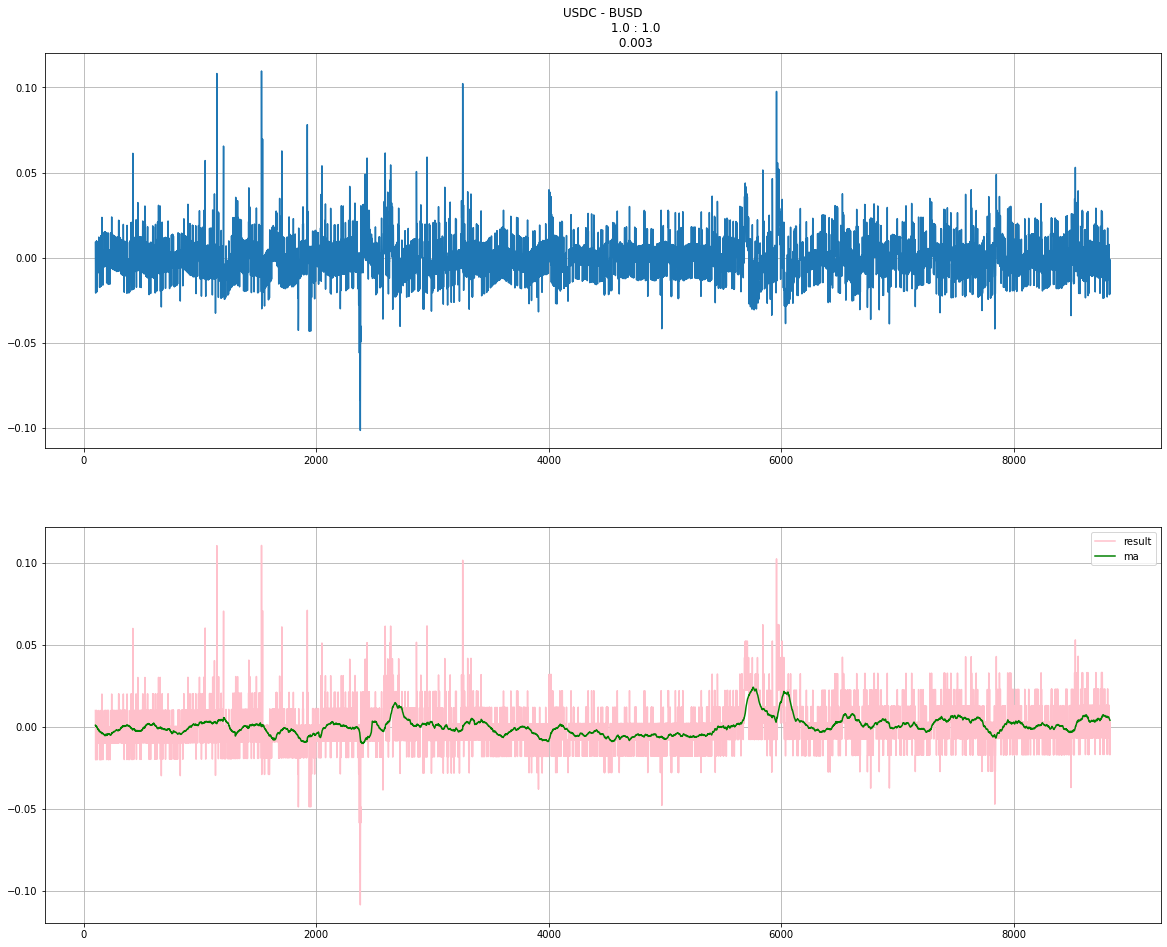

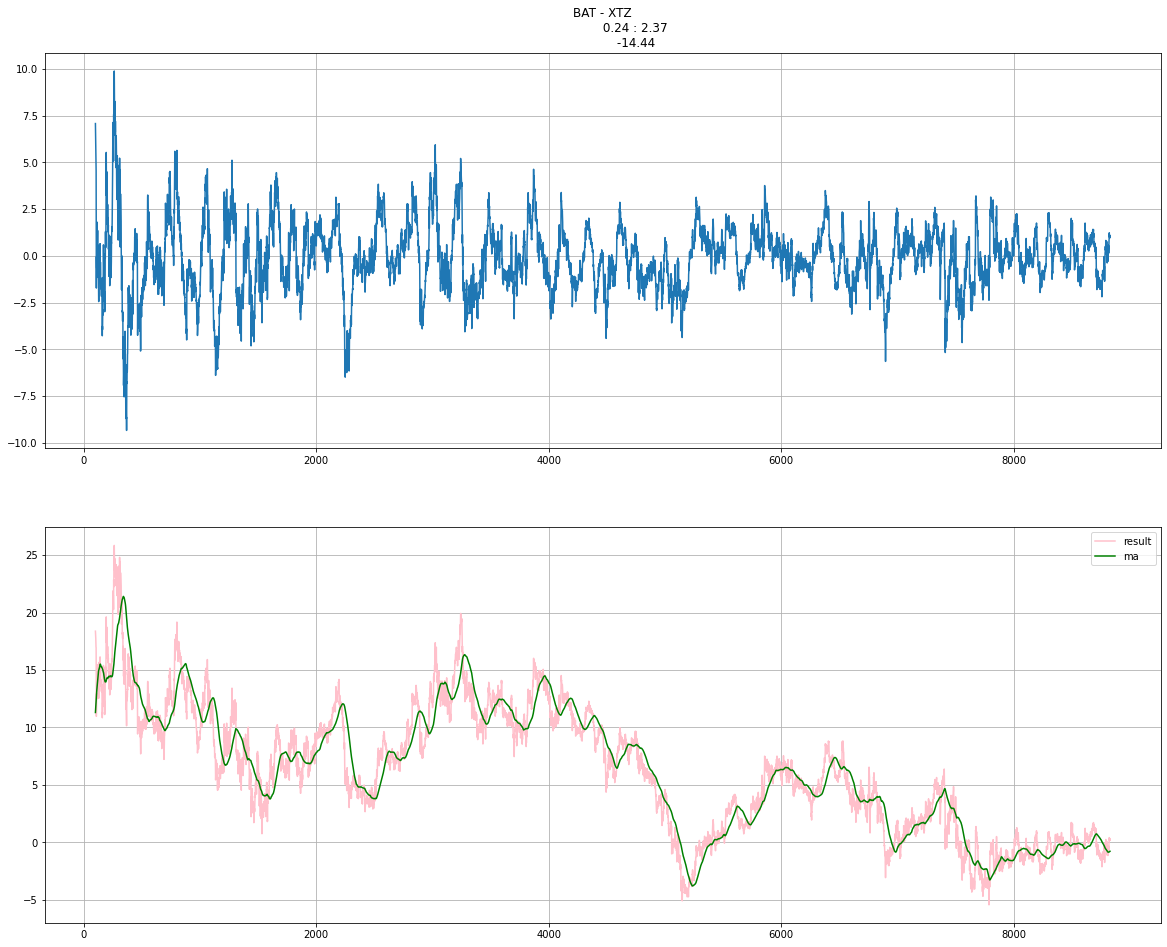

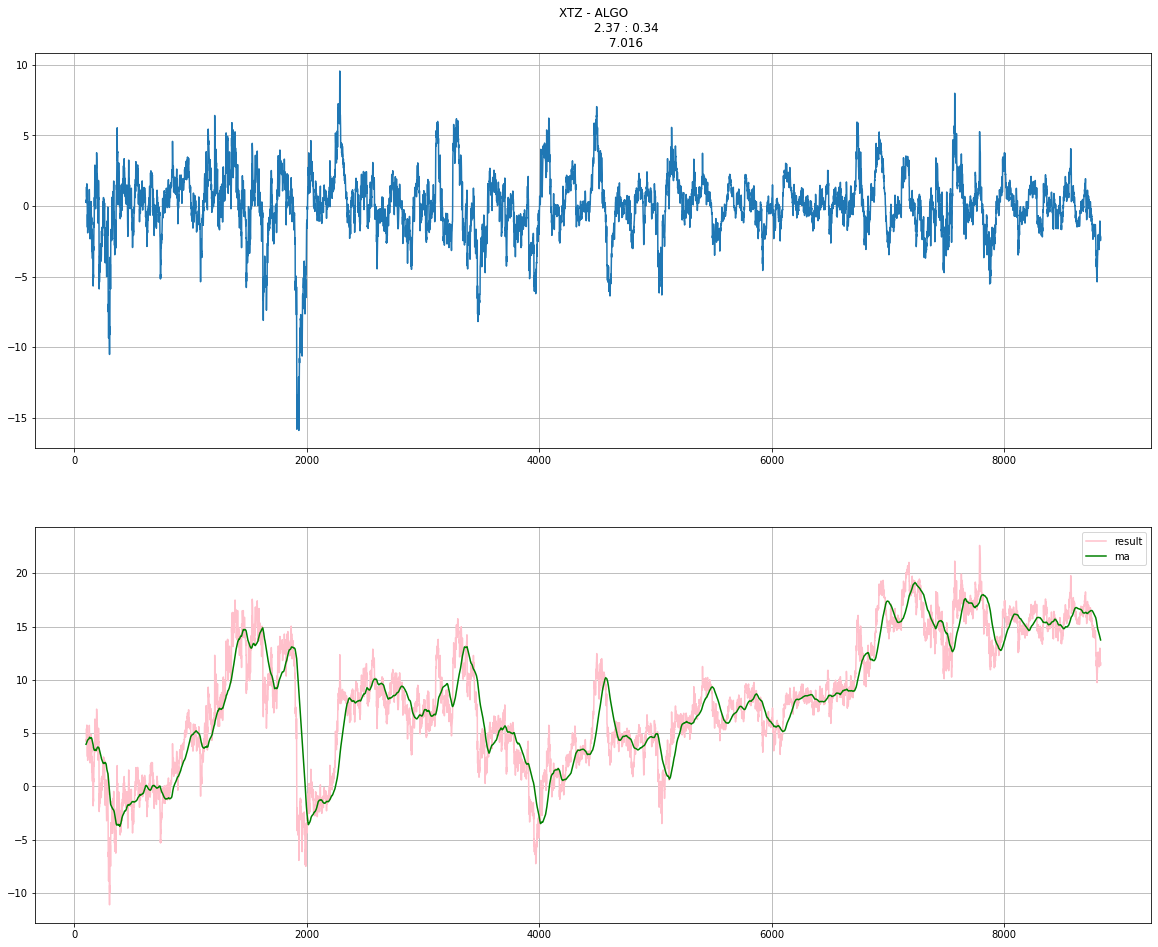

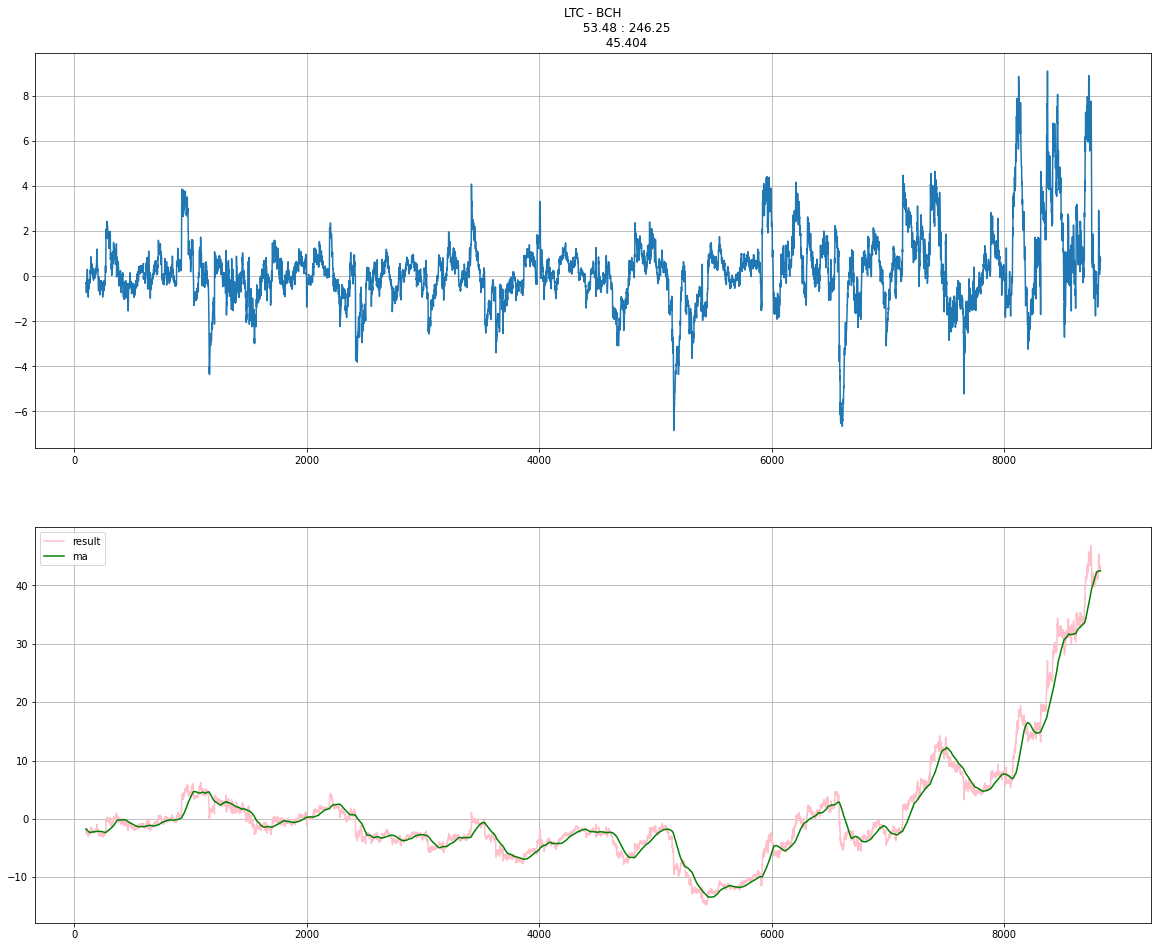

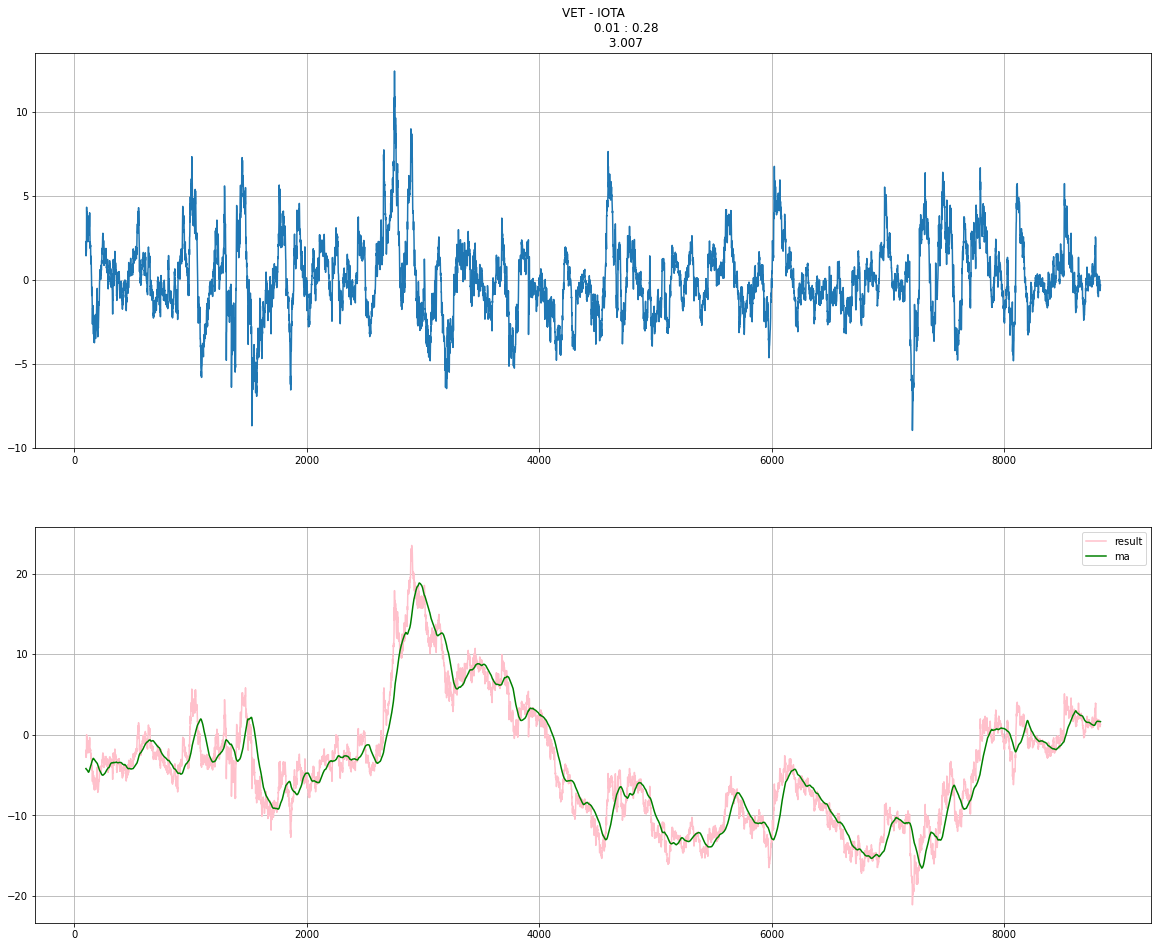

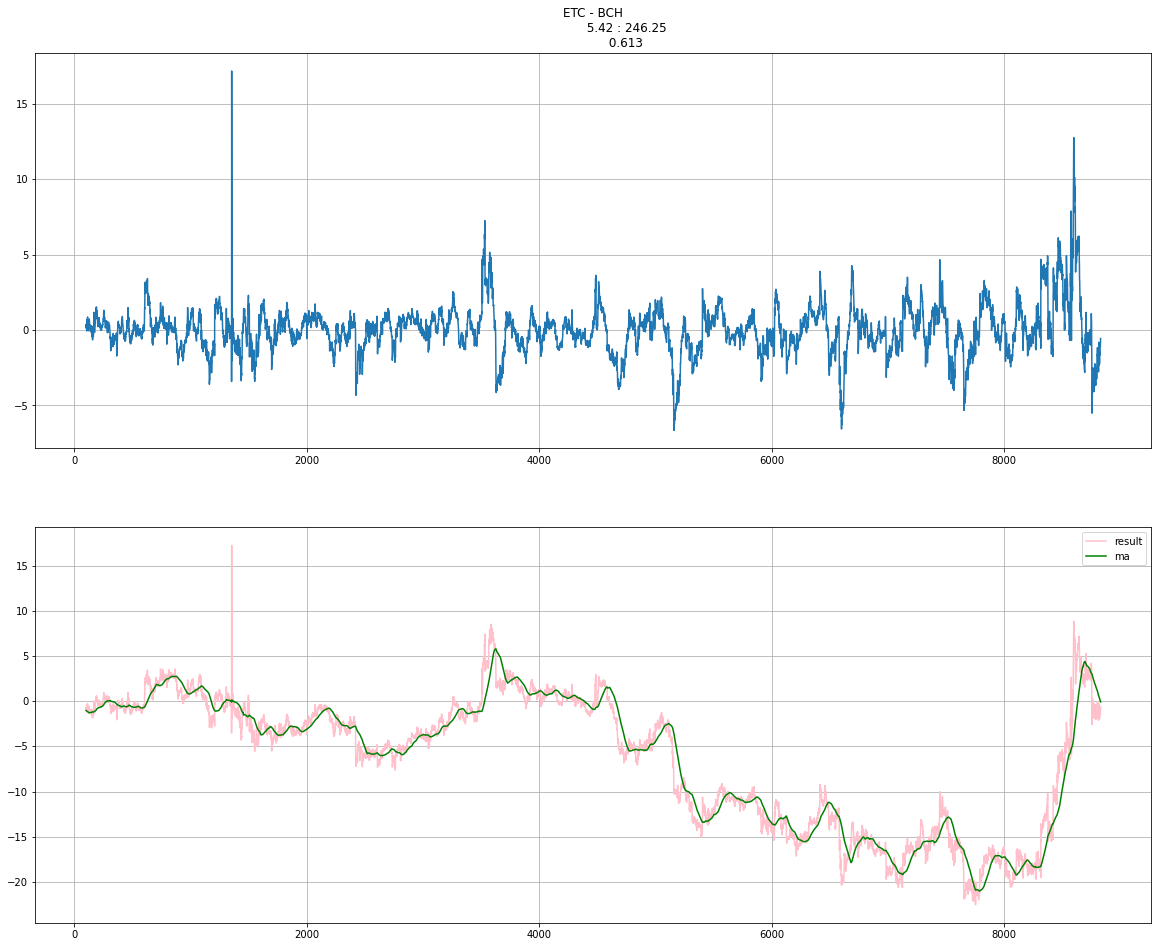

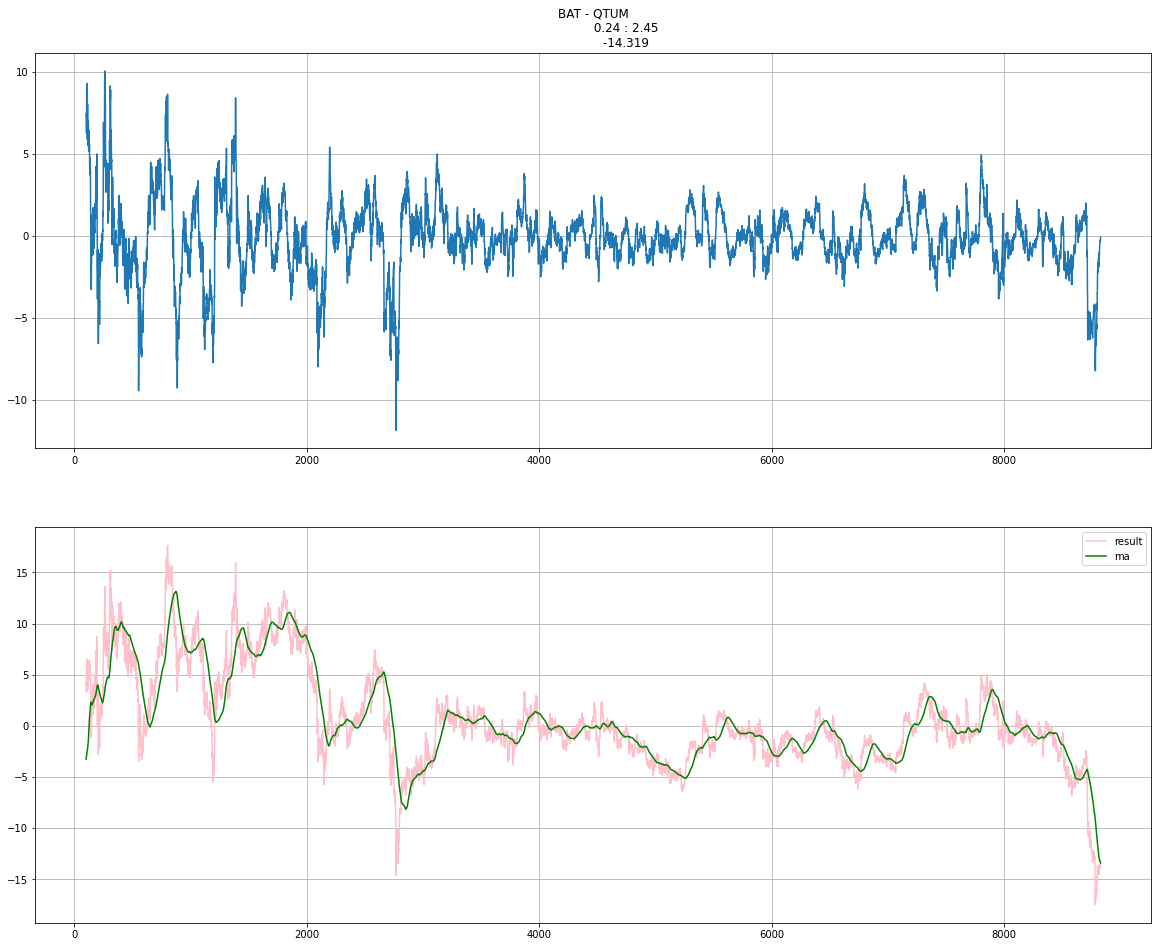

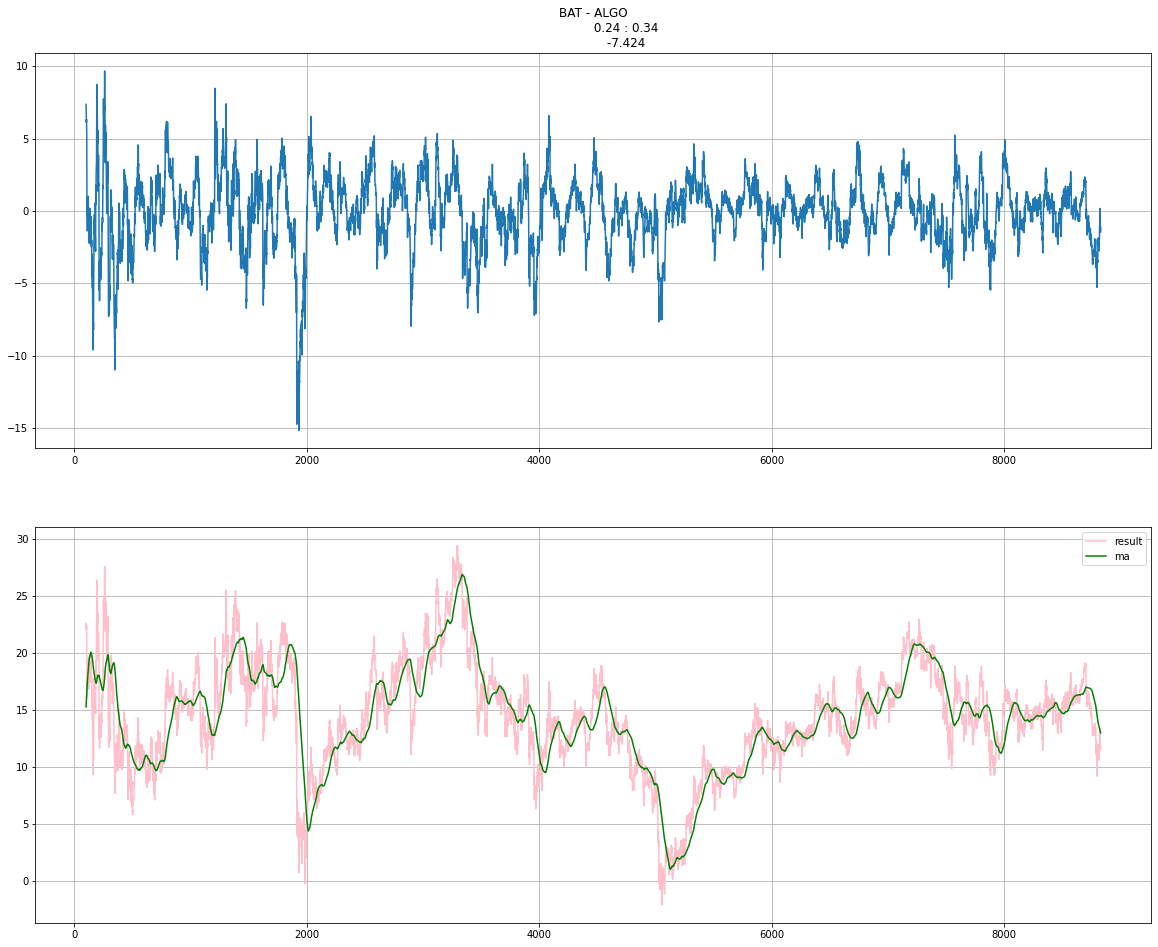

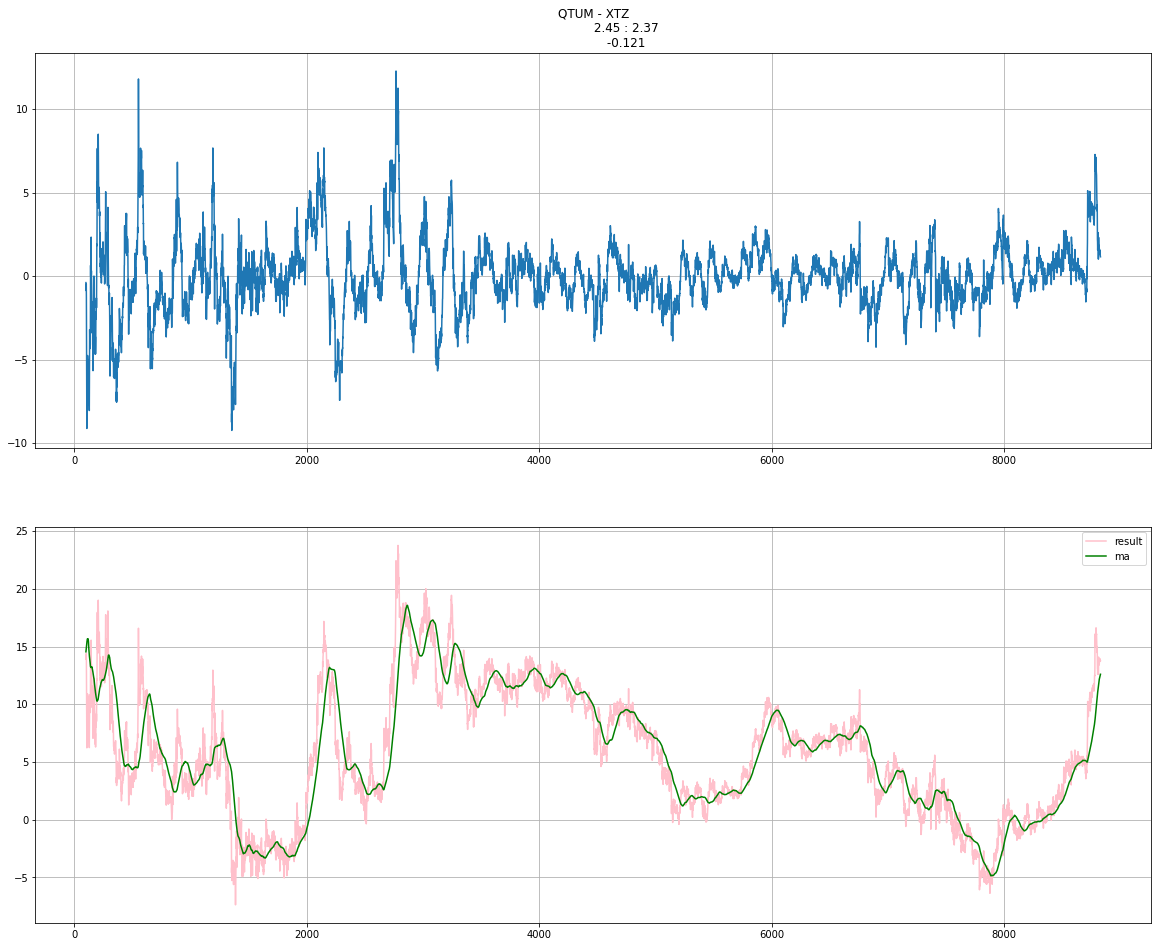

In [40]:
for i in drawing_bases:
    a,b = i.split('-')
    drawing(a,b)

In [44]:
for i in np.array(list(range(20,80,3)))/10:
    trading_df[[str(i), 'time_'+str(i), 'profit_'+str(i), 'loss_'+str(i)]]=0
    for ticker_1, ticker_2 in trading_df.loc[trading_df['corr_coef']>0.85, ['ticker_1','ticker_2']].values:
        base = drawing_bases[ticker_1+'-'+ticker_2][['sum_result','sum-result']][ma:]
        base.dropna(inplace=True)
        fin_result=0
        time = []
        profit=0
        loss=0
        
        trade_type=''
        trade_index=None
        trade_value=None
        for index in base.index:
            value, delta = base.loc[base.index==index, ['sum_result','sum-result']].values[0]
            
            
            if delta <-i and trade_type=='':
                trade_type='long'
                trade_index = index
                trade_value = value
            
            if delta >i and trade_type=='':
                trade_type='short'
                trade_index = index
                trade_value = value
            
            if trade_type=='long' and delta>0:
                fin_result+= value-trade_value-0.4
                time.append((index-trade_index)/6)
                if value-trade_value >0:
                    profit+=1
                else:
                    loss+=1
                
                trade_type = ''
                trade_index=None
                trade_value=None
               
            if trade_type=='short' and delta<0:
                fin_result+= trade_value-value-0.4
                time.append((index-trade_index)/6)
                if trade_value-value >0:
                    profit+=1
                else:
                    loss+=1
            
            
                trade_type = ''
                trade_index=None
                trade_value=None
                
        trading_df.loc[(trading_df.ticker_1==ticker_1)&
                        (trading_df.ticker_2==ticker_2),
                        [str(i), 'time_'+str(i),'profit_'+str(i), 'loss_'+str(i)]] = \
                        [fin_result, np.mean(time) if len(time)!=0 else 0, profit, loss ]

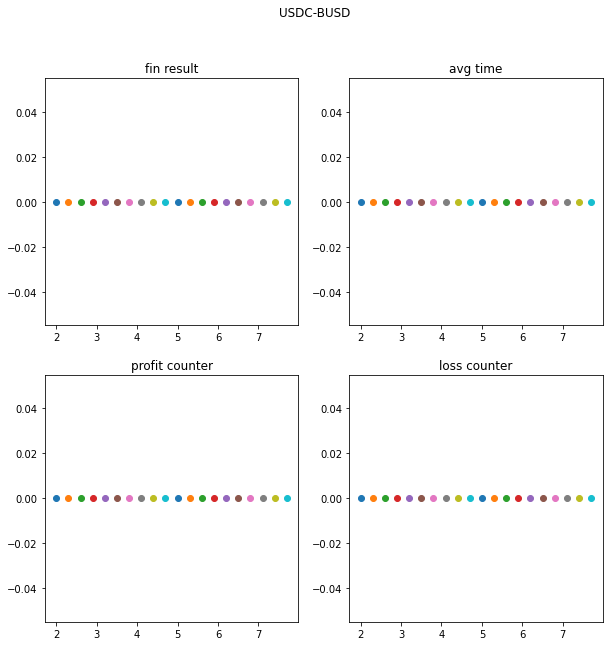

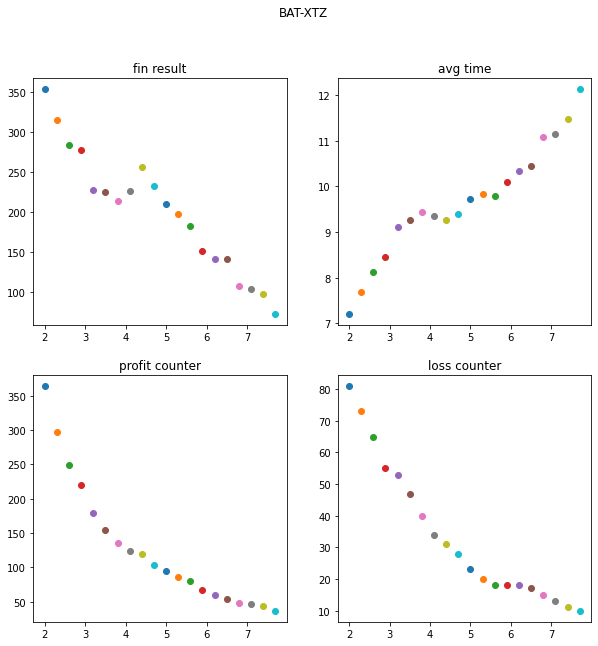

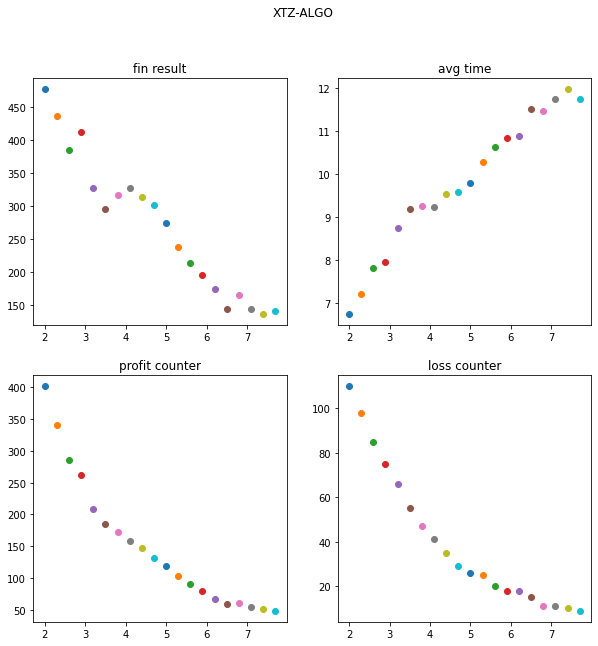

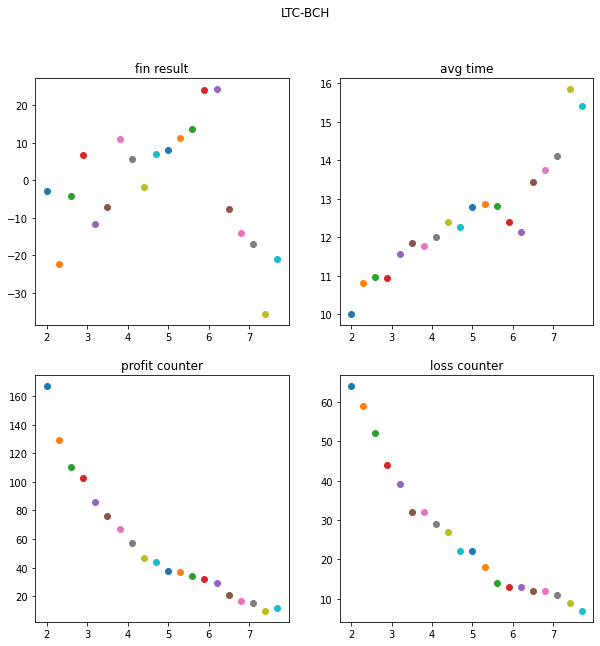

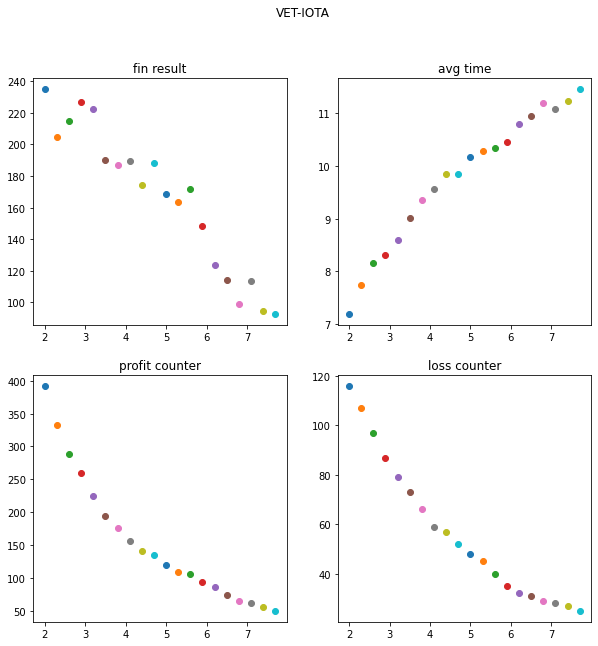

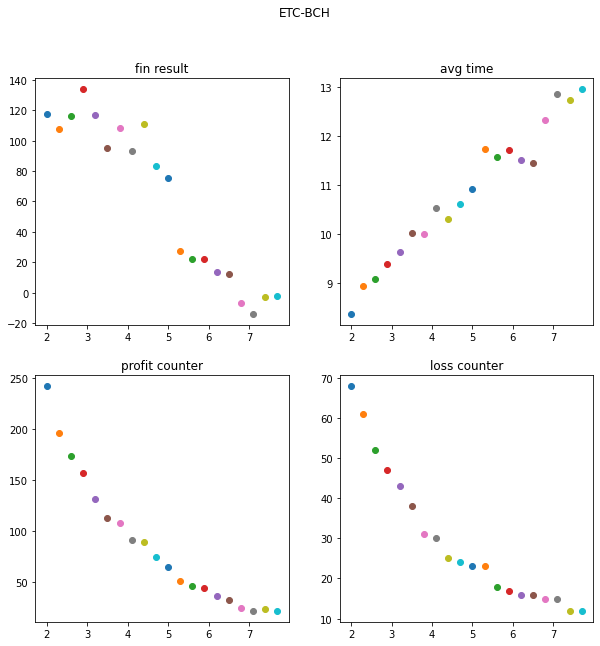

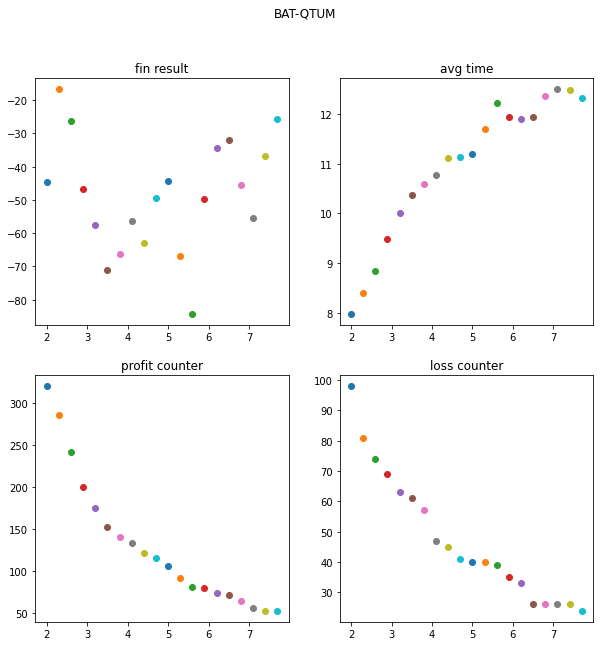

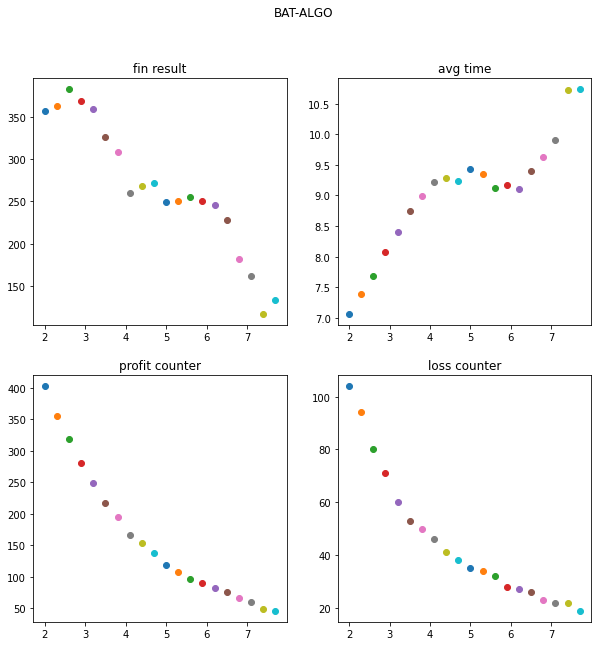

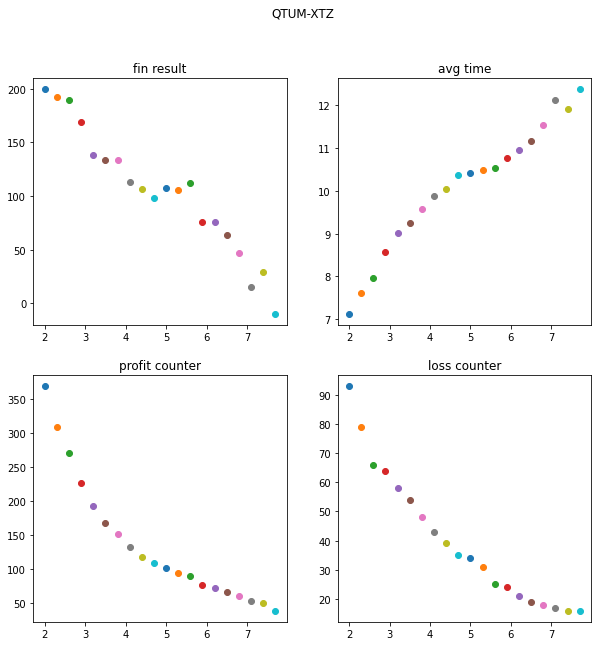

In [45]:
for index in trading_df.loc[trading_df['corr_coef']>0.85].index:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2 , figsize =(10,10))
    b,c = [str(x) for x in trading_df.loc[trading_df.index==index, ['ticker_1', 'ticker_2']].values[0]]
    name = b+'-'+c
    fig.suptitle( name)
    for i in np.array(list(range(20,80,3)))/10:
        ax1.scatter(i,trading_df.loc[trading_df.index==index, str(i)])
        ax1.title.set_text('fin result')
        ax2.scatter(i,trading_df.loc[trading_df.index==index, 'time_'+str(i)])
        ax2.title.set_text('avg time')
        ax3.scatter(i,trading_df.loc[trading_df.index==index, 'profit_'+str(i)])
        ax3.title.set_text('profit counter')
        ax4.scatter(i,trading_df.loc[trading_df.index==index, 'loss_'+str(i)])
        ax4.title.set_text('loss counter')

[2.  2.3 2.6 2.9 3.2 3.5 3.8 4.1 4.4 4.7 5.  5.3 5.6 5.9 6.2 6.5 6.8 7.1
 7.4 7.7]


/tmp/ipykernel_3252/460509118.py:11: RuntimeWarning: invalid value encountered in double_scalars
  hm = fin_result/time*profit/(profit+loss)


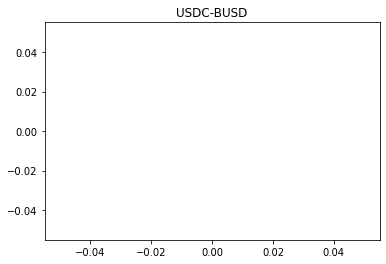

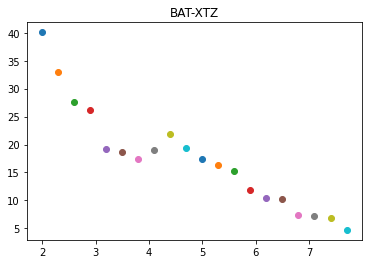

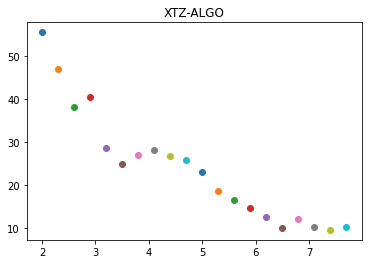

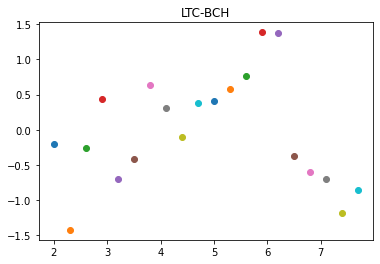

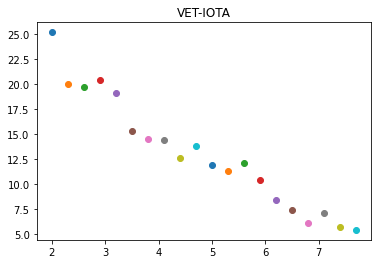

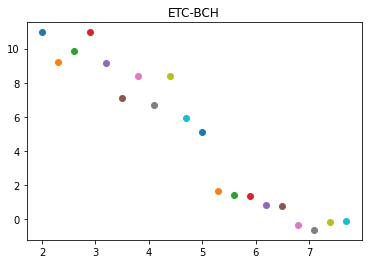

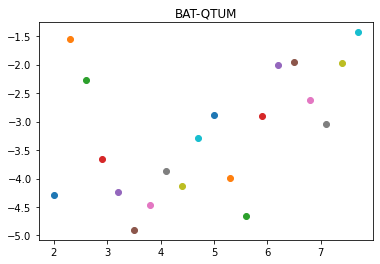

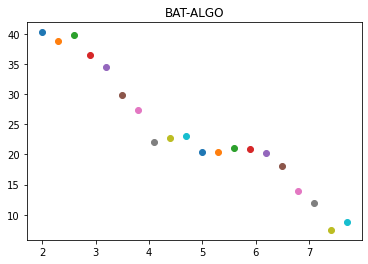

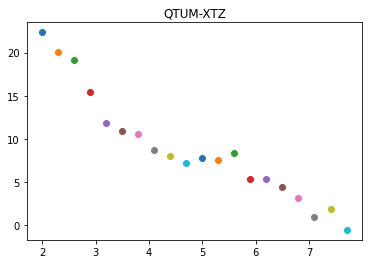

In [47]:
warnings.simplefilter(action='ignore', category=DeprecationWarning)
print(np.array(list(range(20,80,3)))/10)
for index in trading_df.loc[trading_df['corr_coef']>0.85].index:
    b,c = [str(x) for x in trading_df.loc[trading_df.index==index, ['ticker_1', 'ticker_2']].values[0]]
    name = b+'-'+c
    for i in np.array(list(range(20,80,3)))/10:
        fin_result, time, profit, loss = trading_df.loc[trading_df.index==index, [str(i),
                                                                                  'time_'+str(i),
                                                                                  'profit_'+str(i),
                                                                                  'loss_'+str(i)]].values[0]
        hm = fin_result/time*profit/(profit+loss)
        plt.scatter(i, hm)
        plt.title(name)
    plt.show()

In [ ]:
trading = [['XTZ','AKGO',2.9], ['VET','IOTA',2], ['ETC','BCH',2.9], ['BAT','QTUM',2.3]]